In [12]:
%load_ext autoreload
%autoreload 1
%aimport ECGDataset
%aimport Models
%aimport Net
%aimport train_test_validat
%aimport ecg_plot
%aimport logger
import ECGDataset 
import Models 
import Net
from train_test_validat import *
from self_attention import *
import matplotlib.pyplot as plt
import ecg_plot

import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import random
import pandas as pd

import time
import math
import os
import gc
import random


import sys
import logger


from torch.utils.tensorboard import SummaryWriter


time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime()) 
model_path = './model/'+time_str
log_path = './logs/'+  time_str

EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

BATCH_SIZE = 160

FOLDS = 5
EPOCHS = 100  
PATIENCE = 10
LR = 0.01
    
ALLDataset = ECGDataset.ECG_Dataset_Init('/workspace/data/Preprocess_HTN/data_like_pxl//',filter_age= 18,filter_department='外科',rebuild_flage=False)#data_like_pxl_2022
    
def seed_torch(seed=1029):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	# torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	# torch.backends.cudnn.benchmark = False 
	# torch.backends.cudnn.deterministic = True
seed_torch(2023)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda:0
105375
              HTN        NHTN   
   nums       1871      103504  


            orginal            QC         
   nums      105375          66163        
reset size 15
delete size 99
              HTN        NHTN   
   nums       1289      64775   


            orginal   filtered department 
   nums      66064           13896        
              HTN        NHTN   
   nums       1289      12607   


            orginal     removed ages NaN  
   nums      13896           13896        
              HTN        NHTN   
   nums       1289      12607   


            orginal      filtered ages    
   nums      13896           13520        
              HTN        NHTN   
   nums       1273      12247   


            orginal   removed diagnose NaN
   nums      13520           13517        
              HTN        NHTN   
   nums       1282      12235   


ERR labels num: 17


          

In [13]:
Dataset2022 = ECGDataset.ECG_Dataset_Init('/workspace/data/Preprocess_HTN/data_like_pxl_2022//',filter_age= 18,filter_department='外科',rebuild_flage=False)#data_like_pxl_2022

8512
              HTN        NHTN   
   nums       112        8400   


            orginal            QC         
   nums       8512            4761        
reset size 0
delete size 3
              HTN        NHTN   
   nums        85        4673   


            orginal   filtered department 
   nums       4758            1294        
              HTN        NHTN   
   nums        85        1209   


            orginal     removed ages NaN  
   nums       1294            1294        
              HTN        NHTN   
   nums        85        1209   


            orginal      filtered ages    
   nums       1294            1260        
              HTN        NHTN   
   nums        84        1176   


            orginal   removed diagnose NaN
   nums       1260            1259        
              HTN        NHTN   
   nums        84        1175   


ERR labels num: 0


            orginal    removed duplicated 
   nums       1259            1086        
              HTN       

In [4]:
all_dataset = ALLDataset.INFOsDf.copy()
all_dataset = all_dataset.sample(frac=1).reset_index(drop=True) 
print(all_dataset)

         num name  ages gender  diagnose  department      ID  \
0       3450  陈依兰    63      女         0     泌尿外科一病区  867840   
1      39217  陈隆花    48      女         0      普外科二病区  826661   
2      19195  林艺君    31      女         0      神经外科病房  827301   
3        330  卢诗君    30      男         0      普外科一病区  861816   
4      12516  朱为奖    60      男         0  耳鼻喉头颈外科一病区  844575   
...      ...  ...   ...    ...       ...         ...     ...   
11599  22676  王世梅    50      女         0      乳腺外科病房  801193   
11600  18542  林玉芸    39      男         0     泌尿外科一病区  821533   
11601   9273  张文宣    80      男         0      普外科二病区  808852   
11602   2830  苏秀清    73      女         0   肝胆胰血管外科病房  708932   
11603    378  吴明芬    70      女         0   肝胆胰血管外科病房  854648   

                      date                    ecgFN q_sum  
0      2021-06-01 16:34:17  21-6-3450_63-0_NHTN.npy     0  
1      2020-08-19 17:41:24   20-39217_48-0_NHTN.npy     0  
2      2020-08-25 11:46:26   20-19195_31-0_NHTN.npy

In [14]:
test_dataset = ECGDataset.ECG_Dataset('/workspace/data/Preprocess_HTN/data_like_pxl/',ALLDataset.testDf)  # type: ignore  /workspace/data/Preprocess_HTN/data_like_pxl/ECG/21-9-81_36-1_NHTN.npy
test_dataset.datas.shape

torch.Size([4515, 12, 5000])

In [15]:
tv_dataset = ECGDataset.ECG_Dataset('/workspace/data/Preprocess_HTN/data_like_pxl/',ALLDataset.tvDf)  # type: ignore  
tv_dataset.datas.shape

torch.Size([7089, 12, 5000])

In [16]:
test_dataset_2022 = ECGDataset.ECG_Dataset('/workspace/data/Preprocess_HTN/data_like_pxl_2022/',Dataset2022.testDf)  # type: ignore  
test_dataset_2022.datas.shape

torch.Size([1086, 12, 5000])

## PCA 

In [ ]:
from sklearn.decomposition import PCA
import matplotlib

X = tv_dataset.datas.view(7089,-1)
Y = tv_dataset.labels
sklearn_pca = PCA(n_components=2)
data_2d2 = sklearn_pca.fit_transform(X)
cm= matplotlib.colors.ListedColormap(['b','r'])
fig = plt.figure(dpi=300,figsize=(6,6))
ax = fig.add_subplot()
ax.scatter(data_2d2[:, 0], data_2d2[:, 1], c = 'b',alpha=1,s=3,marker=".")

X = test_dataset.datas.view(4515,-1)
Y = test_dataset.labels
sklearn_pca = PCA(n_components=2)
data_2d2 = sklearn_pca.fit_transform(X)
ax.scatter(data_2d2[:, 0], data_2d2[:, 1],c = 'r',alpha=1,s=3,marker=".")
plt.show()

## UMAP

In [17]:
import umap
import matplotlib
import umap.plot

In [17]:
tv_X = tv_dataset.datas.view(tv_dataset.datas.shape[0],-1) # type: ignore
tv_Y = tv_dataset.labels
trans = umap.UMAP(random_state=2023,n_neighbors=5).fit(tv_X)
# ax.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=tv_Y,alpha = 0.5,marker=".")
test_X = test_dataset.datas.view(test_dataset.datas.shape[0],-1) # type: ignore
test_Y = test_dataset.labels
test_embedding = trans.transform(test_X)
# plt.show()
# ax.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=tv_Y,alpha = 0.5,marker=".")
test_X_2022 = test_dataset_2022.datas.view(test_dataset_2022.datas.shape[0],-1) # type: ignore
test_Y_2022 = test_dataset_2022.labels
test_embedding_2022 = trans.transform(test_X_2022)

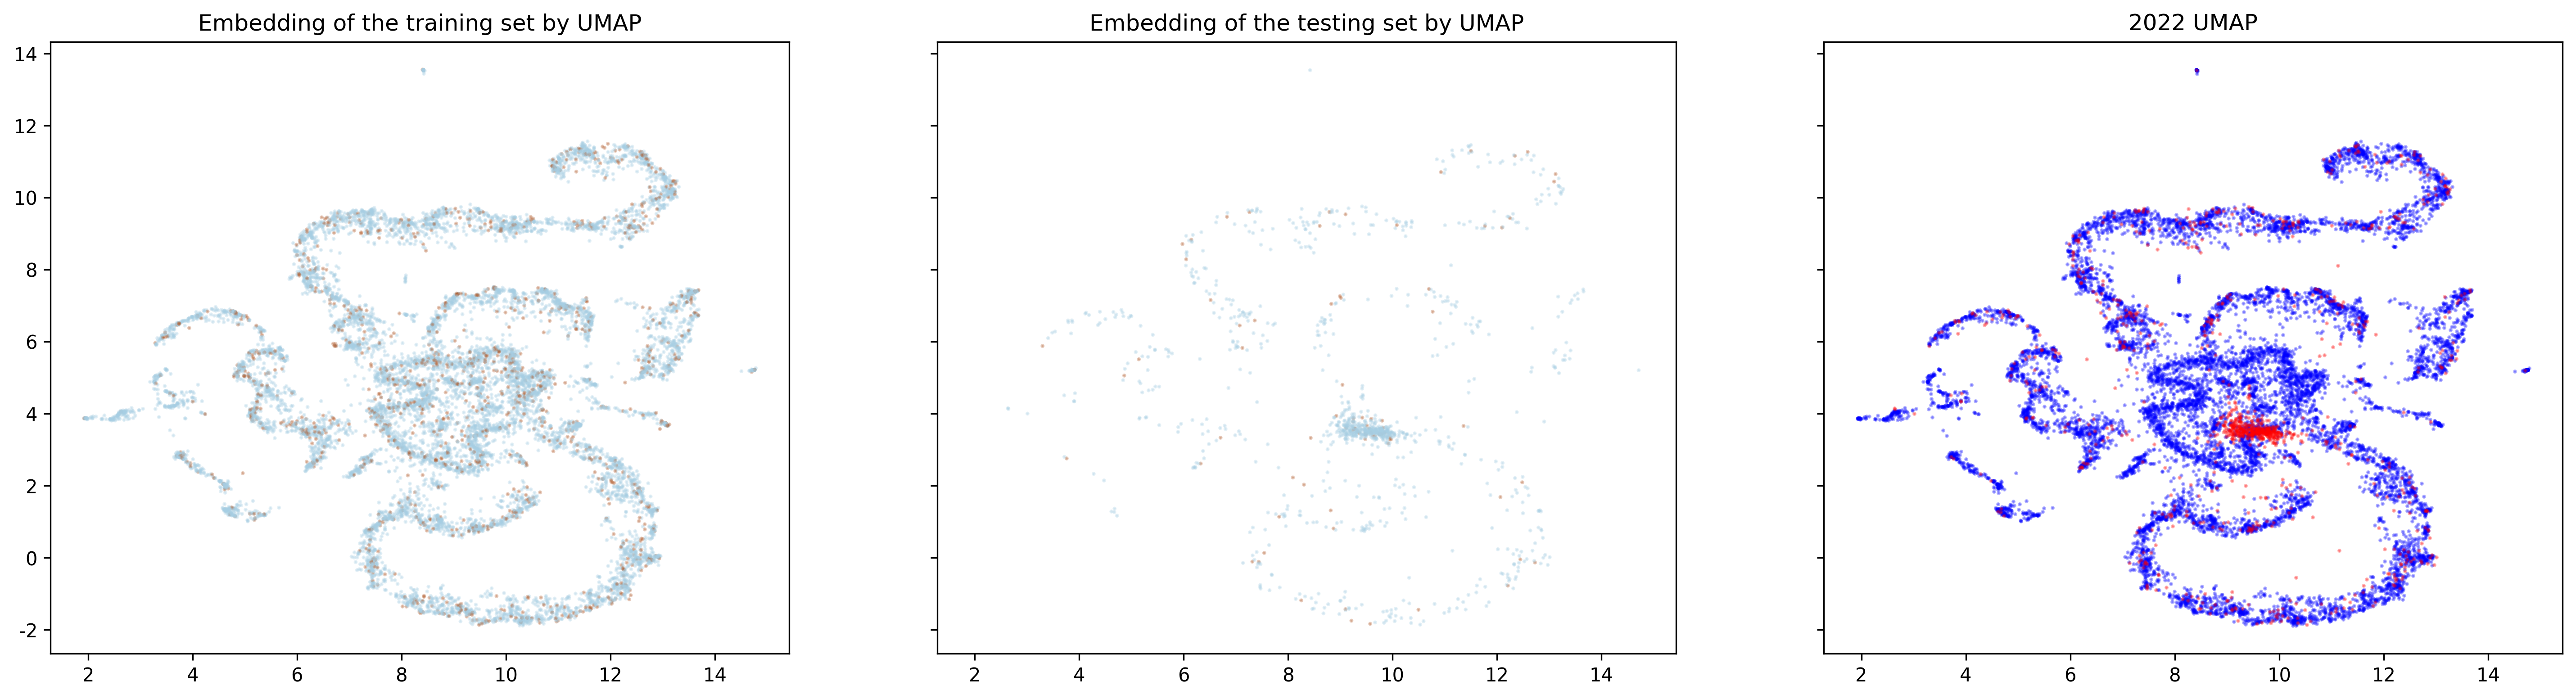

In [18]:
cm= matplotlib.colors.ListedColormap(['b','r']) # type: ignore
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,sharey=True,figsize=(24, 6),dpi=300) # type: ignore

ax0.set_title('Embedding of the training set by UMAP')
# umap.plot.points(trans,labels = tv_Y, color_key_cmap='Paired',ax=ax0)
ax0.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=tv_Y,alpha = 0.3,marker=".",cmap = 'Paired')

ax1.set_title('Embedding of the testing set by UMAP')
ax1.scatter(test_embedding_2022[:, 0], test_embedding_2022[:, 1], s= 5, c=test_Y_2022,alpha = 0.3,marker=".",cmap = 'Paired')

ax2.set_title('2022 UMAP')
# ax2.scatter(test_embedding_2022[:, 0], test_embedding_2022[:, 1], s= 5, c=test_Y_2022,alpha = 0.3,marker=".",cmap = 'Paired')
ax2.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c='b',alpha = 0.3,marker=".")
ax2.scatter(test_embedding_2022[:, 0], test_embedding_2022[:, 1], s= 5, c='r',alpha = 0.3,marker=".")

In [ ]:
tv_Df

In [ ]:
ALLDataset.INFOsDf

In [ ]:
for i in range(5):
    tv_Df = (ALLDataset.tvDf.copy()).reset_index(drop=True)
    tv_Df = tv_Df.sample(frac=1)
    print(tv_Df.index)

In [ ]:
seed_torch(2022)
for i in range(5):
    tv_Df = (ALLDataset.tvDf.copy()).reset_index(drop=True)
    tv_Df = tv_Df.sample(frac=1)
    print(tv_Df.index)

In [ ]:
for i in range(5):
    validate_pair_Df = pair_HTN(tv_Df[(tv_Df['diagnose']==1)],tv_Df[(tv_Df['diagnose']==0)],Range_max = 15,shuffle=True)
    print(validate_pair_Df.index)

In [ ]:
for i in range(5):
    validate_pair_Df = pair_HTN(tv_Df[(tv_Df['diagnose']==1)],tv_Df[(tv_Df['diagnose']==0)],Range_max = 15,shuffle=True)
    print(validate_pair_Df.index)

In [ ]:
test_dataloader = Data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False,pin_memory=True)

In [ ]:
test_infors = (test_dataset.infos.copy()).reset_index()

In [ ]:
test_infors

In [ ]:
y_ture = []
y_pred = []
y_output = [] 
for i,data in enumerate(test_dataloader,0):
    inputs,labels = data[0],data[1]
    outputs = torch.nn.functional.one_hot(labels,2)
    pred = labels
    y_ture.extend((pred.to('cpu').detach().numpy()).tolist())
    y_pred.extend((pred.to('cpu').detach().numpy()).tolist())
    y_output.extend((outputs.to('cpu').detach().numpy()).tolist())            

In [ ]:
ouputs_Df = pd.DataFrame(np.array(y_output),columns=["out0","out1"])
preds_Df = pd.DataFrame(np.array(y_pred),columns=["pred"])
target_Df = pd.DataFrame(np.array(y_ture),columns=["target"])

In [ ]:
ouputs_Df

In [ ]:
test_infors = pd.concat([test_infors,target_Df,preds_Df,ouputs_Df],axis = 1)

In [ ]:
test_infors.to_csv()

In [ ]:
list__ = [0.7785016286644951, 0.6840390879478827, 0.6970684039087948]
(np.array(list__)).mean()

In [ ]:
INFOsDf = ALLDataset.INFOsDf.copy()

In [ ]:
df1 = INFOsDf[(INFOsDf['diagnose'] == 1)] #
df2 = INFOsDf[(~(INFOsDf.duplicated(subset=['ID'],keep=False)))&(INFOsDf['diagnose'] == 0)]
df3 = INFOsDf[((INFOsDf.duplicated(subset=['ID'],keep=False)))&(INFOsDf['diagnose'] == 0)].drop_duplicates(subset=['ID'],keep='last')

print(len(df1)+len(df2)+len(df3))

In [ ]:
INFOsDf[(INFOsDf.duplicated(subset=['ID'],keep=False))&(INFOsDf['diagnose'] == 0)].drop_duplicates(subset=['ID'],keep='last')

In [ ]:
tv_Df = (ALLDataset.tvDf.copy()).reset_index(drop=True)
print(tv_Df.iloc[0][0])
tv_Df = tv_Df.sample(frac=1)#Shuffle before k-fold train
tv_Lables = np.array(tv_Df['diagnose'].tolist())# type: ignore 
strKFold = StratifiedKFold(n_splits=FOLDS, shuffle=False)  # shuffle 参数用于确定在分类前是否对数据进行打乱清洗
for train_index, val_index in strKFold.split(np.zeros(len(tv_Lables)),tv_Lables):
    train_infos = tv_Df.iloc[train_index].reset_index(drop=True) # type: ignore        
    val_infos = tv_Df.iloc[val_index].reset_index(drop=True) # type: ignore  
    print(len(train_infos[train_infos['diagnose'] == 0]),len(train_infos[train_infos['diagnose'] == 1]))
    print(len(val_infos[val_infos['diagnose'] == 0]),len(val_infos[val_infos['diagnose'] == 1]))
    # print(val_infos[val_infos['diagnose'] == 1])

In [ ]:
import augmenters

In [ ]:
x = torch.zeros((2,12,5000))
y = torch.zeros((2,1))

In [ ]:
augmenters.gen_baseline_wander(x,500,prob=torch.rand(1))


In [ ]:
ecg_plot.plot(augmenters.gen_baseline_wander(x,500,prob=torch.rand(1))[0],500,'',columns=2,row_height= 3,show_grid=True,show_separate_line=True)  # type: ignore

In [ ]:
testdf = ALLDataset.INFOsDf.copy()

In [ ]:
df1 = testdf[testdf['ID']=='']
df1 = df1.sort_values(by=['diagnose'], ascending=[False]) #按照诊断排序，HTN在前
df1[df1.duplicated(subset=['name','ages','gender'])]

In [ ]:
df2 = testdf[~(testdf['ID']=='')]
df2 = df2.sort_values(by=['diagnose'], ascending=[False]) #按照诊断排序，HTN在前
df2_0 = df2[df2['diagnose']==0] #所有非高血压
df2_1 = df2[df2['diagnose']==1] #所有高血压

duplicated_index = df2_0[[True if i in df2_1['ID'].tolist() else False for i in df2_0['ID']]].index
df2.loc[duplicated_index,'diagnose'] = 1


In [ ]:
df2 = df2.sort_values(by=['diagnose'], ascending=[False]) #按照诊断排序，HTN在前
df2_0 = df2[df2['diagnose']==0] #所有非高血压
df2_1 = df2[df2['diagnose']==1] #所有高血压

duplicated_index = df2_0[[True if i in df2_1['ID'].tolist() else False for i in df2_0['ID']]].index

In [ ]:
ALLDataset.testDf[(ALLDataset.testDf['diagnose']==1)]['ages'].hist(color='b', alpha=0.5, bins=50)
ALLDataset.testDf[(ALLDataset.testDf['diagnose']==0)]['ages'].hist(color='r', alpha=0.5, bins=50)

In [ ]:
ALLDataset.tvDf[(ALLDataset.tvDf['diagnose']==1)]['ages'].hist(color='b', alpha=0.5, bins=50)
ALLDataset.tvDf[(ALLDataset.tvDf['diagnose']==0)]['ages'].hist(color='r', alpha=0.5, bins=50)

In [ ]:
ALLDataset.testDf[(ALLDataset.testDf['diagnose']==1)]['ages'].plot(kind='kde',color='b')
ALLDataset.testDf[(ALLDataset.testDf['diagnose']==0)]['ages'].plot(kind='kde',color='r')

In [ ]:
ALLDataset.tvDf[(ALLDataset.tvDf['diagnose']==1)]['ages'].plot(kind='kde',color='b')
ALLDataset.tvDf[(ALLDataset.tvDf['diagnose']==0)]['ages'].plot(kind='kde',color='r')

In [ ]:
def pair_HTN(INPUT_HTN_Df,INPUT_NHTN_Df,Range_max = 10,shuffle = False):
    HTN_Df = ((INPUT_HTN_Df).copy())
    NHTN_Df = ((INPUT_NHTN_Df).copy())#即抽即删,抽出一条删一条
    if(shuffle): #打乱
        HTN_Df = (HTN_Df.sample(frac=1))
        NHTN_Df = (NHTN_Df.sample(frac=1))
    # pair_Df = INFOs_df = pd.DataFrame(index=range(len(HTN_Df)*2),columns=HTN_Df.columns)   #所有的HNT和抽取出来的NHTN都存放入其中
    pair_Df = HTN_Df #先将所有HTN存放入其中
    index = len(HTN_Df)
    for info in HTN_Df.itertuples():
        age = info.ages
        gender = info.gender
        candidate_NHTN_Df = pd.DataFrame()
        
        for Range in range(1,Range_max): # 在 ±Range_max 范围内搜寻ages，且gender相同的NHTN样本
            candidate_NHTN_Df = NHTN_Df[(NHTN_Df['ages']>age-Range)&(NHTN_Df['ages']<age+Range)&(NHTN_Df['gender']==gender)]
            if(len(candidate_NHTN_Df) > 0):
                break
        
        if(len(candidate_NHTN_Df)<1):# ±Range_max 范围内都没有，那么就从所有NHTN样本（删除掉之前被抽到的）中抽一个
            print("lack sample like :",info)
            candidate_NHTN_Df = NHTN_Df
        NHTN_data_buff = candidate_NHTN_Df.sample(n=1) #从candida中随机抽样一个
        # pair_Df.iloc[index] = NHTN_data_buff.iloc[0]
        pair_Df = pair_Df.append(NHTN_data_buff)
        # print(age,',',NHTN_data_buff['ages'])
        # print(NHTN_data_buff.index)
        NHTN_Df = NHTN_Df.drop(index= (NHTN_data_buff.index))
        index = index +1
    return pair_Df
        
            

In [ ]:
testsize = len(ALLDataset.tvDf[(ALLDataset.tvDf['diagnose']==1)])//5
# print(testsize)
for i in range(5):
    All_df = ALLDataset.tvDf.copy()    
    validate_pair_Df = pair_HTN(All_df[(All_df['diagnose']==1)].iloc[testsize*i:testsize*i+testsize],All_df[(All_df['diagnose']==0)],Range_max = 15)
    validate_dataset = ECGDataset.ECG_Dataset('/workspace/data/Preprocess_HTN/data_like_pxl//',validate_pair_Df)
    All_df = All_df.drop(index= validate_pair_Df.index)    #删掉validate_pair_Df
    train_pair_Df_ = pair_HTN(All_df[(All_df['diagnose']==1)],All_df[(All_df['diagnose']==0)],Range_max = 15)
    
    

In [ ]:
Model = Net.MLBFNet(2)

In [ ]:
x,y = validate_dataset.__getitem__(0)
Model(x)

In [ ]:
from scipy.signal import butter, lfilter

In [ ]:
filter_lowcut = 1.0
filter_highcut = 47.0
filter_order = 1

In [ ]:

def bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data)
        return y

In [ ]:
X,Y = test_dataset.__getitem__(0)
ecg_plot.plot(X/100,500,(test_dataset.info(0)).tolist(),columns=2,row_height= 8,show_grid=True,show_separate_line=True)  # type: ignore

In [ ]:
X_filtet = bandpass_filter(X, lowcut=filter_lowcut, highcut=filter_highcut, signal_freq=500, filter_order=filter_order)# type: ignore  

In [ ]:
ecg_plot.plot(X_filtet/100,500,(test_dataset.info(0)).tolist(),columns=2,row_height= 8,show_grid=True,show_separate_line=True)  # type: ignore